In [1]:
%%capture
!pip install pandas matplotlib seaborn librosa

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
from typing import Dict, List

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [3]:
def create_tess_train_dataframe(
    path: str,
    subfolders: List
) -> pd.DataFrame:
    """
    Creates a TESS' pandas DataFrame containing
    all the training files.
    
    Args:
        path (str): the path to the CSV file.
    
    Returns:
        df (pd.DataFrame): the pandas DataFrame.
    """
    df = pd.DataFrame()
    
    for subfolder in subfolders:
        full_path = os.path.join(path, subfolder)
        label = subfolder.split("_")[-1]
        wav_files = [
            file
            for file in os.listdir(full_path)
            if file.endswith(".wav")
        ]
        
        row = pd.DataFrame({
            "file": [os.path.join(path, subfolder, wav) for wav in wav_files],
            "label": [label] * len(wav_files)
        })
        
        df = pd.concat(
            [df, row],
            axis=0
        )
    
    return df.reset_index(drop=True)

def create_propor_train_dataframe(
    path: str
) -> pd.DataFrame:
    """
    Creates a PROPOR 2022's pandas DataFrame containing
    all the training files using the same structure as the
    `test_ser_metadata.csv` file.
    
    Args:
        path (str): the path to the CSV file.
    
    Returns:
        df (pd.DataFrame): the pandas DataFrame.
    """
    wav_files = [
        file
        for file in os.listdir(path)
        if file.endswith(".wav")
    ]
    df = pd.DataFrame()
    
    for wav in wav_files:
        wav_file = os.path.basename(wav)
        wav_file = wav_file.split("/")[0]
        label = wav_file.split("_")[-1].replace(".wav", "")
        
        row = pd.DataFrame({
            "file": [wav_file],
            "label": [label],
            "wav_file": [wav_file]
        })
        
        df = pd.concat(
            [df, row],
            axis=0
        )
    
    return df.reset_index(drop=True)

def check_sample_rates(
    df: pd.DataFrame
) -> Dict:
    """
    Checks the sample rate for each audio file within a folder
    (to see if more than one unique sample rate is found).
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        Dict: a dict which the keys are the sample rate values and its
              values are a list with the corresponding audio file name.
    """
    wav_files = df["wav_file"].unique().tolist()
    rates = {}
    
    for wav in wav_files:
        try:
            _, sr = librosa.load(wav, mono=False, sr=None)

            if sr not in rates.keys():
                rates[sr] = [wav]
            else:
                rates[sr].append(wav)
        except:
            print(f"Error in file {wav}")
    
    return rates

def check_number_of_channels(
    df: pd.DataFrame
) -> Dict:
    """
    Checks the number of channels (stereo or mono) for each audio file
    within a folder (to see if more than one is found).
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        Dict: a dict which the keys are the channel and its
              values are a list with the corresponding audio file name.
    """
    wav_files = df["wav_file"].unique().tolist()
    number_channels = {}
    
    for wav in wav_files:
        try:
            audio, _ = librosa.load(wav, mono=False, sr=None)
            channels = "mono" if audio.ndim == 1 else "stereo"

            if channels not in number_channels.keys():
                number_channels[channels] = [wav]
            else:
                number_channels[channels].append(wav)
        except:
            print(f"Error in file {wav}")
            
    return number_channels

def get_duration(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Creates a new column on the dataframe containing the duration
    in seconds of each audio file.
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        pd.DataFrame: the metadata dataframe with the duration
                      of each file added.
    """
    df["duration"] = df["wav_file"].apply(
        lambda x: librosa.get_duration(filename=x)
    )
    return df

def plot_file_duration(
    df: pd.DataFrame,
    top_n: int
) -> None:
    """
    Plot the duration of the files.
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    """
    df = df.sort_values("duration", ascending=False)
    
    if top_n > 0:
        df = df[:top_n]
    elif top_n < 0:
        df = df[top_n:]
        
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df,
        x="wav_file",
        y="duration",
        color="cornflowerblue"
    )
    plt.xlabel("File name")
    plt.xticks(rotation=90)
    plt.ylabel("Duration (in seconds)")
    plt.title("File duration")
    plt.show()

### PROPOR 2022

In [4]:
propor_train_path = "/media/greca/HD/Datasets/PROPOR 2022/data_train/train"
propor_train_df = create_propor_train_dataframe(propor_train_path)
propor_train_df["wav_file"] = propor_train_df["wav_file"].apply(lambda x: os.path.join(propor_train_path, x))
propor_train_df.head()

,file,label,wav_file
0,bpubdl02_segment247_non-neutral-male.wav,non-neutral-male,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
1,bpubmn14_segment89_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
2,bfamdl26_segment93_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
3,bfammn27_segment275_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
4,bfamcv02_segment276_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/data_trai...


In [5]:
propor_rates = check_sample_rates(
    df=propor_train_df
)

propor_rates_unique = list(set(list(propor_rates.keys())))

if len(propor_rates_unique) == 1:
    print(f"Sample rate of {propor_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {propor_rates_unique}")

Sample rate of 16000 found!


In [6]:
propor_num_channels = check_number_of_channels(
    df=propor_train_df
)

propor_unique_num_channels = list(set(list(propor_num_channels.keys())))

if len(propor_unique_num_channels) == 1:
    print(f"The files are {propor_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [7]:
propor_train_df["label"] = propor_train_df["label"].replace({
    "neutral": "neutro",
    "non-neutral-male": "homem não-neutro",
    "non-neutral-female": "mulher não-neutro"
})

propor_train_df.head()

,file,label,wav_file
0,bpubdl02_segment247_non-neutral-male.wav,homem não-neutro,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
1,bpubmn14_segment89_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
2,bfamdl26_segment93_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
3,bfammn27_segment275_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/data_trai...
4,bfamcv02_segment276_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/data_trai...


In [8]:
propor_train_df = get_duration(
    df=propor_train_df
)

print(sum(propor_train_df["duration"])/60)

39.37970520833338


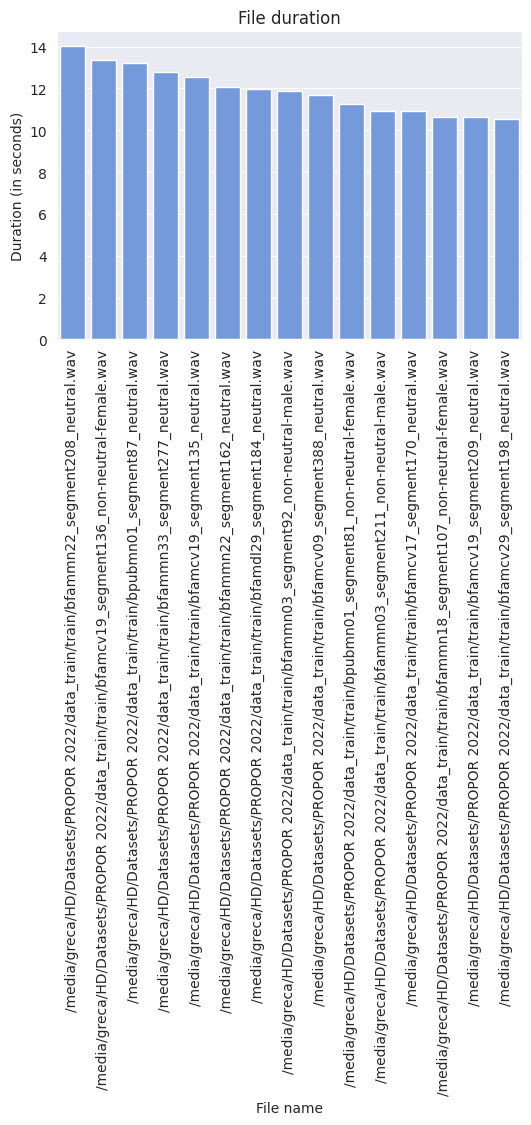

In [9]:
plot_file_duration(propor_train_df, top_n=15)

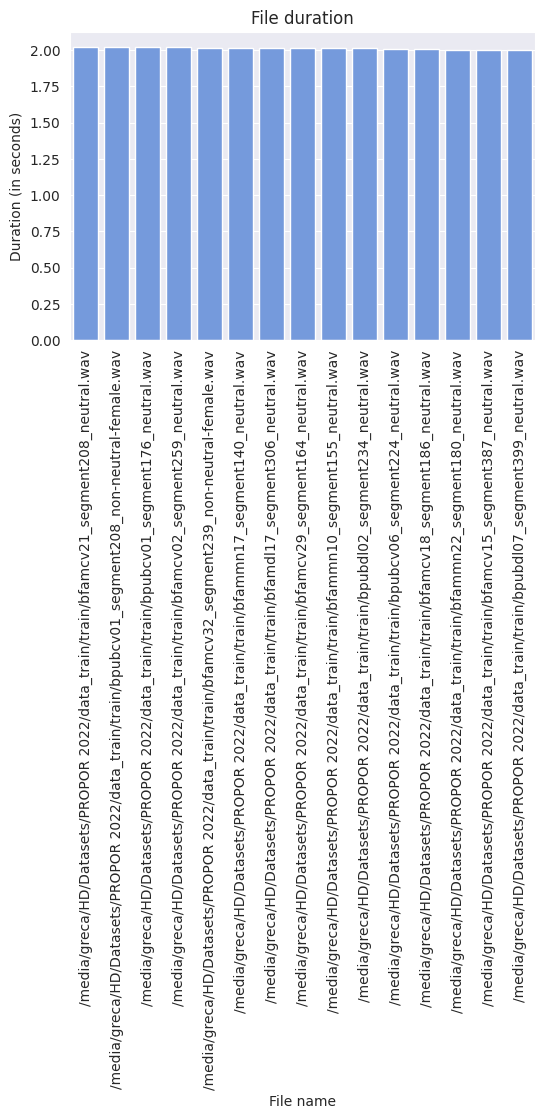

In [10]:
plot_file_duration(propor_train_df, top_n=-15)

In [11]:
propor_test_path = "/media/greca/HD/Datasets/PROPOR 2022/test_ser_metadata.csv"
propor_test_audio_path = "/media/greca/HD/Datasets/PROPOR 2022/test_ser"
propor_test_df = pd.read_csv(propor_test_path, sep=",")
propor_test_df["wav_file"] = propor_test_df["wav_file"].apply(lambda x: os.path.join(propor_test_audio_path, x))
propor_test_df.head()

,file,label,wav_file
0,bfamcv32_segment244_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
1,bfamcv05_segment338_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
2,bpubcv01_segment300_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
3,bfamcv29_segment258_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
4,bpubdl07_segment234_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...


In [12]:
propor_rates = check_sample_rates(
    df=propor_test_df
)

propor_rates_unique = list(set(list(propor_rates.keys())))

if len(propor_rates_unique) == 1:
    print(f"Sample rate of {propor_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {propor_rates_unique}")

Sample rate of 16000 found!


In [13]:
propor_num_channels = check_number_of_channels(
    df=propor_test_df
)

propor_unique_num_channels = list(set(list(propor_num_channels.keys())))

if len(propor_unique_num_channels) == 1:
    print(f"The files are {propor_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [14]:
propor_test_df["label"] = propor_test_df["label"].replace({
    "neutral": "neutro",
    "non-neutral-male": "homem não-neutro",
    "non-neutral-female": "mulher não-neutro"
})

propor_test_df.head()

,file,label,wav_file
0,bfamcv32_segment244_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
1,bfamcv05_segment338_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
2,bpubcv01_segment300_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
3,bfamcv29_segment258_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
4,bpubdl07_segment234_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...


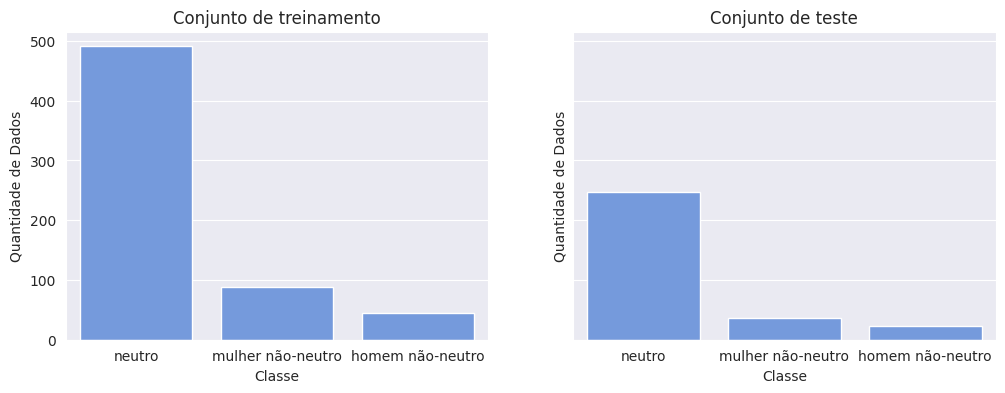

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

df_gby_train = propor_train_df.groupby("label").agg({"wav_file": "count"})
df_gby_train = df_gby_train.reset_index()
df_gby_train = df_gby_train.sort_values("label", ascending=False)
df_gby_train = df_gby_train.reset_index()

df_gby_test = propor_test_df.groupby("label").agg({"wav_file": "count"})
df_gby_test = df_gby_test.reset_index()
df_gby_test = df_gby_test.sort_values("label", ascending=False)
df_gby_test = df_gby_test.reset_index()

sns.barplot(
    data=df_gby_train,
    x="label",
    y="wav_file",
    color="cornflowerblue",
    ax=ax1
)
ax1.set_title("Conjunto de treinamento")
ax1.set_ylabel("Quantidade de Dados")
ax1.set_xlabel("Classe")

sns.barplot(
    data=df_gby_test,
    x="label",
    y="wav_file",
    color="cornflowerblue",
    ax=ax2
)
ax2.set_title("Conjunto de teste")
ax2.set_ylabel("Quantidade de Dados")
ax2.set_xlabel("Classe")
plt.savefig("../images/distribuição_coraa.png")

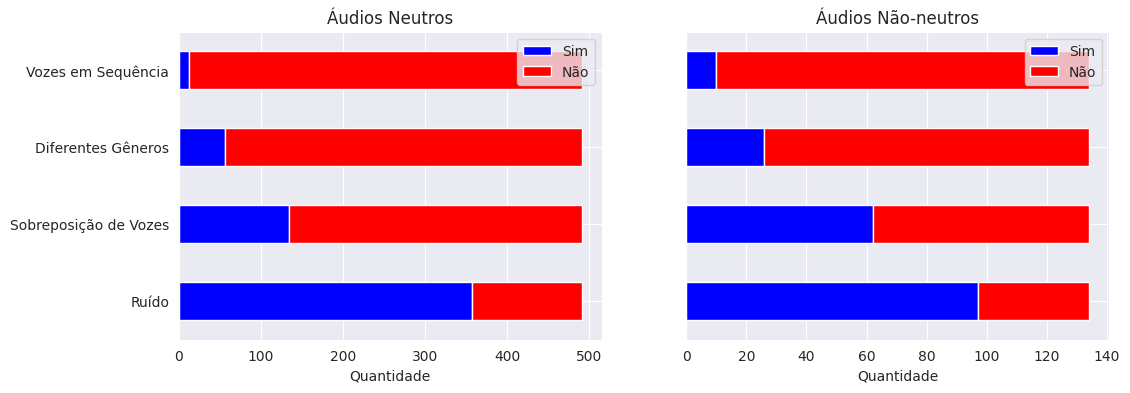

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=True)

df = pd.DataFrame({
    "Sim": [357, 134, 56, 12],
    "Não": [134, 357, 435, 479]
}, index=["Ruído", "Sobreposição de Vozes", "Diferentes Gêneros", "Vozes em Sequência"])

df.plot(kind="barh", stacked=True, color=["blue", "red"], ax=ax1)
ax1.set_xlabel("Quantidade")
ax1.set_title("Áudios Neutros")
ax1.legend(loc="best")

df = pd.DataFrame({
    "Sim": [97, 62, 26, 10],
    "Não": [37, 72, 108, 124]
}, index=["Ruído", "Sobreposição de Vozes", "Diferentes Gêneros", "Vozes em Sequência"])

df.plot(kind="barh", stacked=True, color=["blue", "red"], ax=ax2)
ax2.set_xlabel("Quantidade")
ax2.set_title("Áudios Não-neutros")
ax2.legend(loc="best")

plt.savefig("../images/grafico_adaptado_coraa.png")

In [17]:
propor_test_df = get_duration(
    df=propor_test_df
)

print(sum(propor_test_df["duration"])/60)

20.829270833333336


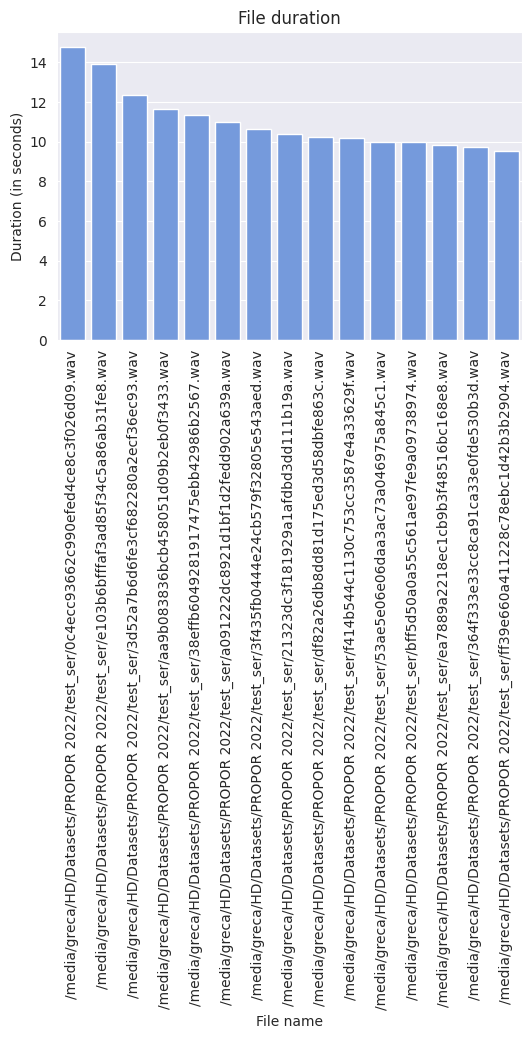

In [18]:
plot_file_duration(propor_test_df, top_n=15)

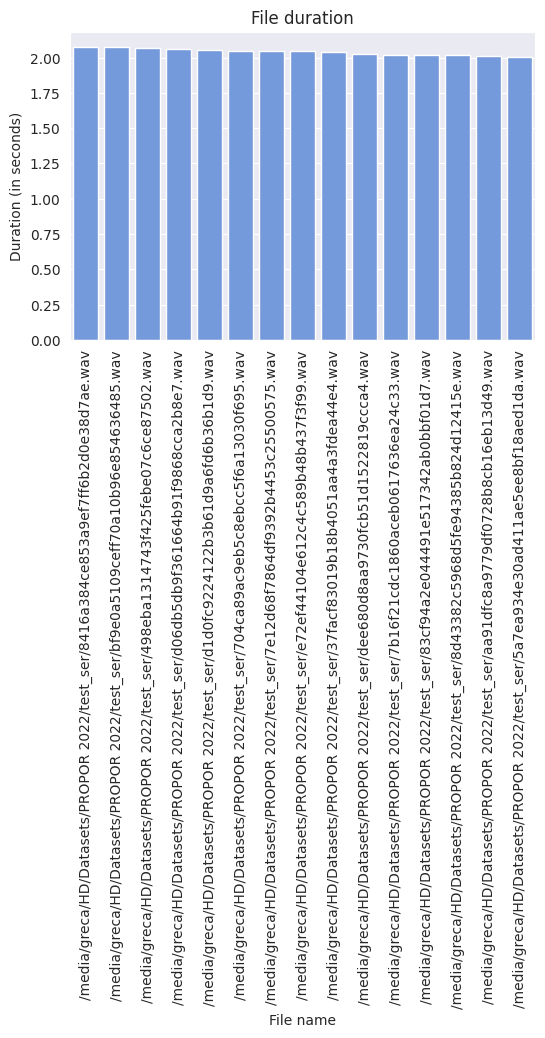

In [19]:
plot_file_duration(propor_test_df, top_n=-15)

### TESS

In [28]:
valid_oaf_subfolders = ["OAF_angry", "OAF_disgust", "OAF_fear", "OAF_happy", "OAF_neutral", "OAF_pleasant_surprised", "OAF_sad"]
valid_yaf_subfolders = ["YAF_angry", "YAF_disgust", "YAF_fear", "YAF_happy", "YAF_neutral", "YAF_pleasant_surprised", "YAF_sad"]
tess_train_path = "/media/greca/HD/Datasets/TESS Toronto emotional speech set data"

oaf_df = create_tess_train_dataframe(
    path=tess_train_path,
    subfolders=valid_oaf_subfolders
)

yaf_df = create_tess_train_dataframe(
    path=tess_train_path,
    subfolders=valid_yaf_subfolders
)

tess_train_df = pd.concat(
    [oaf_df, yaf_df],
    axis=0
).reset_index(drop=True)

del oaf_df, yaf_df

In [29]:
tess_train_df = tess_train_df.rename(columns={"file": "wav_file"})
tess_train_df.head()

,wav_file,label
0,/media/greca/HD/Datasets/TESS Toronto emotiona...,angry
1,/media/greca/HD/Datasets/TESS Toronto emotiona...,angry
2,/media/greca/HD/Datasets/TESS Toronto emotiona...,angry
3,/media/greca/HD/Datasets/TESS Toronto emotiona...,angry
4,/media/greca/HD/Datasets/TESS Toronto emotiona...,angry


In [30]:
tess_rates = check_sample_rates(
    df=tess_train_df
)

tess_rates_unique = list(set(list(tess_rates.keys())))

if len(tess_rates_unique) == 1:
    print(f"Sample rate of {tess_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {tess_rates_unique}")

Different sample were rates found! [96000, 24414]


In [31]:
tess_num_channels = check_number_of_channels(
    df=tess_train_df
)

tess_unique_num_channels = list(set(list(tess_num_channels.keys())))

if len(tess_unique_num_channels) == 1:
    print(f"The files are {tess_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [32]:
tess_train_df["label"] = tess_train_df["label"].replace({
    "angry": "raiva",
    "fear": "medo",
    "happy": "felicidade",
    "neutral": "neutro",
    "disgust": "nojo",
    "sad": "tristeza",
    "surprised": "surpresa"
})

tess_train_df.head()

,wav_file,label
0,/media/greca/HD/Datasets/TESS Toronto emotiona...,raiva
1,/media/greca/HD/Datasets/TESS Toronto emotiona...,raiva
2,/media/greca/HD/Datasets/TESS Toronto emotiona...,raiva
3,/media/greca/HD/Datasets/TESS Toronto emotiona...,raiva
4,/media/greca/HD/Datasets/TESS Toronto emotiona...,raiva


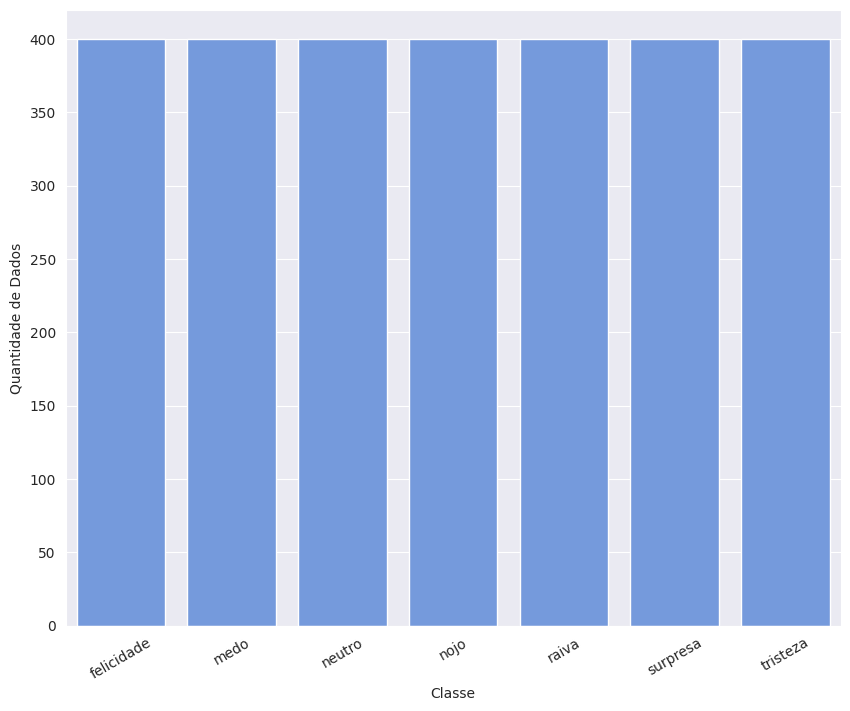

In [33]:
plt.figure(figsize=(10, 8))

tess_train_df2 = tess_train_df.groupby("label").agg({"wav_file": "count"})
tess_train_df2 = tess_train_df2.reset_index()

sns.barplot(
    data=tess_train_df2,
    x="label",
    y="wav_file",
    color="cornflowerblue"
)
plt.ylabel("Quantidade de Dados")
plt.xlabel("Classe")
plt.xticks(rotation=30)
plt.savefig("../images/distribuição_tess.png")

In [34]:
tess_train_df = get_duration(
    df=tess_train_df
)

print(sum(tess_train_df["duration"])/60)

95.9058621107081


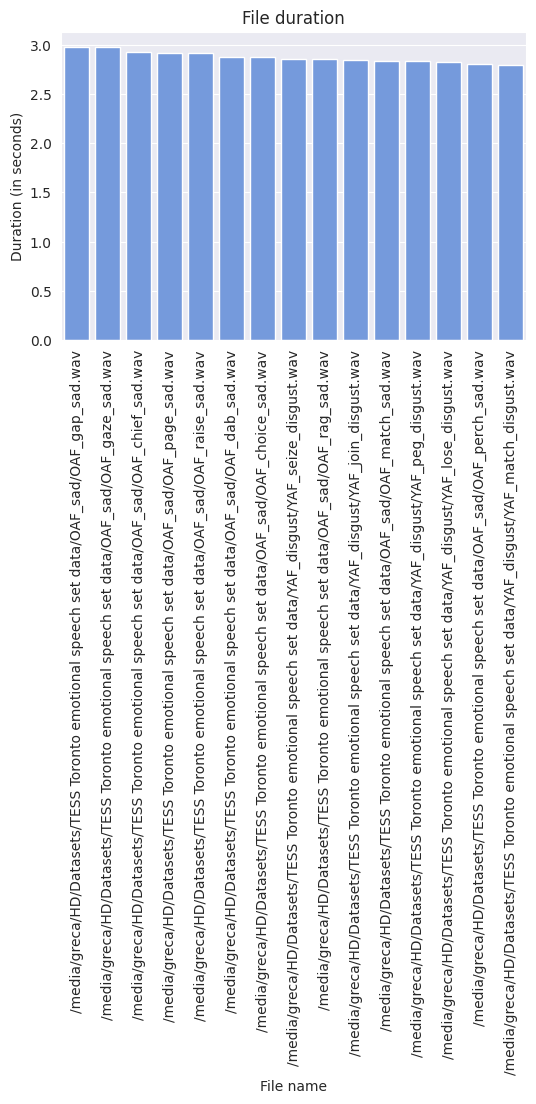

In [35]:
plot_file_duration(tess_train_df, top_n=15)

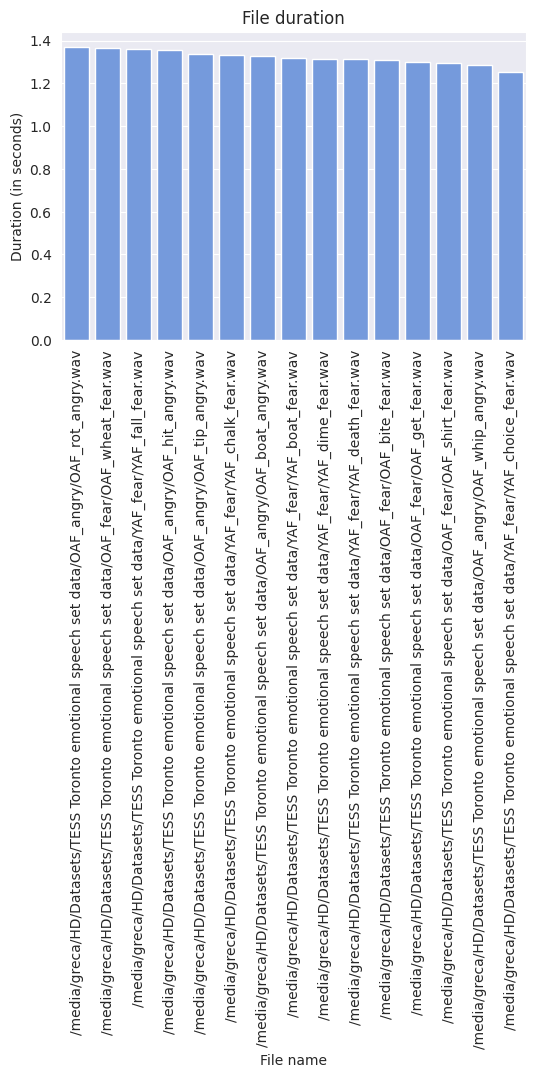

In [36]:
plot_file_duration(tess_train_df, top_n=-15)